# TechNation AI Exposure Analysis

This notebook analyzes AI exposure in jobs using a large dataset from TechNation. We load the full dataset, perform quality analysis, sample a reduced dataset for visualization, conduct demographic and occupational analysis (including labor force characteristics, immigration status, and population groups), and generate insightful charts.

**Key Sections:**
- Data Loading and Quality Analysis
- Sampling Reduced Dataset
- Exploratory Analysis
- Visualizations (Grouped Charts)
- Key Insights

<button onclick="toggleCode()">Toggle All Code</button>
<script>
function toggleCode() {
    var cells = document.querySelectorAll('div.input');
    cells.forEach(function(cell) {
        cell.style.display = cell.style.display === 'none' ? 'block' : 'none';
    });
}
</script>

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Imports
!pip -q install pyarrow pandas
import pyarrow.dataset as ds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import re
import textwrap
from matplotlib.backends.backend_pdf import PdfPages

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")


[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## Data Loading and Quality Analysis

In [5]:
DATA_DIR = "final_data_parquet"

# Inspect schema first (optional)
dataset = ds.dataset(DATA_DIR, format="parquet")
print(dataset.schema)

# Load (optionally pick columns=['col1','col2',...])
table = dataset.to_table()          # or: to_table(columns=[...])
df = table.to_pandas()

df.head()

year: int64
province: string
noc_norm: dictionary<values=string, indices=int8, ordered=0>
population_group: string
lf_characteristic: string
age_group: string
sex: string
immigrant_and_generation_status: string
value_x: double
value_y: double
median_income: double
average_income: double
ai_exposure: double
-- schema metadata --
pandas: '{"index_columns": [], "column_indexes": [], "columns": [{"name":' + 1710


,year,province,noc_norm,population_group,lf_characteristic,age_group,sex,immigrant_and_generation_status,value_x,value_y,median_income,average_income,ai_exposure
0,2022,National,"Business, finance and administration occupatio...",Arab,Employment,15 to 24 years,Both sexes,Admitted to Canada in the last 10 years,0.0,NaN,5280.0,5200.0,1.126681
1,2022,National,"Business, finance and administration occupatio...",Arab,Employment,15 to 24 years,Both sexes,Admitted to Canada in the last 10 years,0.0,NaN,3880.0,5390.0,1.126681
2,2022,National,"Business, finance and administration occupatio...",Arab,Employment,15 to 24 years,Both sexes,Admitted to Canada in the last 10 years,0.0,NaN,2300.0,4040.0,1.126681
3,2022,National,"Business, finance and administration occupatio...",Arab,Employment,15 to 24 years,Both sexes,Admitted to Canada in the last 10 years,0.0,NaN,3120.0,5320.0,1.126681
4,2022,National,"Business, finance and administration occupatio...",Arab,Employment,15 to 24 years,Both sexes,Admitted to Canada in the last 10 years,0.0,NaN,3120.0,5320.0,1.126681


In [8]:
# Column Data Quality Analysis
print("COLUMN DATA QUALITY ANALYSIS - FULL DATASET")
print("=" * 80)

column_analysis = []
total_rows = len(df)

for column in df.columns:
    # NaN values
    nan_count = df[column].isna().sum()
    nan_pct = (nan_count / total_rows) * 100

    # Zeros for numeric
    if df[column].dtype in ['int64', 'float64']:
        zero_count = (df[column] == 0).sum()
        zero_pct = (zero_count / total_rows) * 100
    else:
        zero_count = zero_pct = 0

    # Empty strings for object
    if df[column].dtype == 'object':
        empty_count = (df[column].astype(str).str.strip() == '').sum()
        empty_pct = (empty_count / total_rows) * 100
    else:
        empty_count = empty_pct = 0

    total_problematic = nan_count + zero_count + empty_count
    total_problematic_pct = (total_problematic / total_rows) * 100

    column_analysis.append({
        'column': column,
        'dtype': str(df[column].dtype),
        'total_rows': total_rows,
        'nan_count': nan_count,
        'nan_%': nan_pct,
        'zero_count': zero_count,
        'zero_%': zero_pct,
        'empty_count': empty_count,
        'empty_%': empty_pct,
        'total_problematic': total_problematic,
        'total_problematic_%': total_problematic_pct
    })

# Analysis DataFrame
analysis_df = pd.DataFrame(column_analysis).sort_values('total_problematic_%', ascending=False)

print(f"Total dataset size: {len(df):,} rows × {len(df.columns)} columns")
print("\n" + "=" * 80)
print("DETAILED COLUMN ANALYSIS:")
print("=" * 80)

pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
print(analysis_df.to_string(formatters={
    'nan_%': '{:.2f}%'.format,
    'zero_%': '{:.2f}%'.format,
    'empty_%': '{:.2f}%'.format,
    'total_problematic_%': '{:.2f}%'.format
}))
pd.reset_option('display.max_rows')
pd.reset_option('display.width')

COLUMN DATA QUALITY ANALYSIS - FULL DATASET
Total dataset size: 30,719,304 rows × 13 columns

DETAILED COLUMN ANALYSIS:
                             column     dtype  total_rows  nan_count  nan_%  zero_count zero_%  empty_count empty_%  total_problematic total_problematic_%
9                           value_y   float64    30719304   27383301 89.14%           0  0.00%            0   0.00%           27383301              89.14%
8                           value_x   float64    30719304     303864  0.99%    13207832 43.00%            0   0.00%           13511696              43.98%
10                    median_income   float64    30719304     959607  3.12%     1012473  3.30%            0   0.00%            1972080               6.42%
11                   average_income   float64    30719304          0  0.00%     1012473  3.30%            0   0.00%            1012473               3.30%
0                              year     int64    30719304          0  0.00%           0  0.00%           

## Sampling Reduced Dataset

Sample 2M rows for efficient analysis and visualization.

In [9]:
print("=" * 80)
print("CREATING REDUCED DATASET (2M ROWS)")
print("=" * 80)

df_reduced = df.sample(n=2000000, random_state=42)
print(f"Reduced dataset shape: {df_reduced.shape}")
display(df_reduced.head())

CREATING REDUCED DATASET (2M ROWS)
Reduced dataset shape: (2000000, 13)


,year,province,noc_norm,population_group,lf_characteristic,age_group,sex,immigrant_and_generation_status,value_x,value_y,median_income,average_income,ai_exposure
29267889,2022,National,Natural and applied sciences and related occup...,Visible minority n.i.e,Employment rate,15 to 24 years,Females,Non-permanent residents,0.0,NaN,6280.0,9100.0,0.314283
20699689,2024,National,"Management occupations [00,10,20,30,40,50,60,7...",Visible minority population,Unemployment,15 to 24 years,Males,Admitted to Canada in the last 10 years,6432.0,NaN,9200.0,13480.0,0.694525
2940615,2022,National,"Occupations in manufacturing and utilities, ex...",Latin American,Unemployment,65 years and over,Females,Non-immigrants,0.0,NaN,0.0,0.0,-0.816774
9791563,2023,National,Natural and applied sciences and related occup...,Japanese,Employment rate,15 years and over,Males,Second generation,3990.0,4697.183333,70500.0,85500.0,0.314283
14277160,2023,National,"Occupations in manufacturing and utilities, ex...",Not a visible minority,Labour force,65 years and over,Both sexes,Immigrants,208266.0,NaN,472.0,10120.0,-0.816774


## Exploratory Analysis

Prepare derived variables and aggregates for charts.

In [10]:
def emp_weighted_avg(g):
    g = g.dropna(subset=['ai_exposure', 'value_x'])
    if g['value_x'].sum() == 0 or len(g) == 0 == 0:
        return np.nan
    return np.average(g['ai_exposure'], weights=g['value_x'])


In [11]:
# Create AI exposure categories
df_reduced['ai_category'] = pd.cut(df_reduced['ai_exposure'],
                                  bins=[0, 0.3, 0.6, 1.0],
                                  labels=['Low (0-0.3)', 'Medium (0.3-0.6)', 'High (0.6-1.0)'])

# Demographic aggregates
gender_ai = df_reduced.groupby("sex", dropna=False).apply(emp_weighted_avg).sort_values(ascending=False)

def order_age(labels):
    def key(s):
        s = str(s)
        m = re.search(r"(\d+)", s)
        return int(m.group(1)) if m else 10**9
    return sorted(labels, key=key)

age_order = order_age(df_reduced["age_group"].dropna().unique())
age_ai = (df_reduced.groupby("age_group", dropna=False).apply(emp_weighted_avg).reindex(age_order).dropna())

immigrant_ai = (df_reduced.groupby("immigrant_and_generation_status", dropna=False).apply(emp_weighted_avg).sort_values(ascending=False))

if "population_group" in df_reduced.columns:
    pop_group_ai = (df_reduced.groupby("population_group", dropna=False).apply(emp_weighted_avg).sort_values(ascending=False))
else:
    pop_group_ai = pd.Series(dtype=float)

# NEW: Labor Force Characteristics aggregate
if "lf_characteristic" in df_reduced.columns:
    lf_ai = (df_reduced.groupby("lf_characteristic", dropna=False).apply(emp_weighted_avg).sort_values(ascending=False))
else:
    lf_ai = pd.Series(dtype=float)

# Top occupations
top_occupations = df_reduced['noc_norm'].value_counts().head(15).index
occupation_ai = df_reduced[df_reduced['noc_norm'].isin(top_occupations)]
occupation_means = occupation_ai.groupby('noc_norm').apply(emp_weighted_avg).sort_values(ascending=True)

# High AI subset
threshold = 0.7
df_reduced['high_exposure'] = (df_reduced['ai_exposure'] >= threshold).astype(int)

share_by_gender = (
    df_reduced.groupby('sex', dropna=False)
              .apply(lambda g: g['value_x'].dot(g['high_exposure']) / g['value_x'].sum())
              .reset_index(name='share_high_exposure')
)

high_ai = df_reduced['high_exposure']
high_ai_gender = share_by_gender

summary = (
    df_reduced.groupby(['province', 'population_group', 'year'], dropna=False)
      .apply(lambda g: g['value_x'].dot(g['high_exposure']) / g['value_x'].sum() if g['value_x'].sum() > 0 else np.nan)
      .reset_index(name='share_high_exposure')
)


# Income aggregates ##Weighted income analysis
income_by_ai = (df_reduced.groupby('ai_category').apply(lambda g: np.average(g['average_income'], weights=g['value_x']) if g['value_x'].sum() > 0 else np.nan))
ai_cat_counts = (df_reduced.groupby('ai_category')['value_x'].sum().sort_values(ascending=False))

In [12]:
def bootstrap_weighted_mean(values, weights, n_boot=1000, seed=0):
    """
    Returns ((ci_low, ci_high), boot_mean)
    """
    values = np.asarray(values)
    weights = np.asarray(weights)
    mask = (~np.isnan(values)) & (~np.isnan(weights))
    values = values[mask]
    weights = weights[mask]
    if len(values) == 0:
        return (np.nan, np.nan), np.nan
    rng = np.random.default_rng(seed)
    idx = np.arange(len(values))
    boot_means = []
    for _ in range(n_boot):
        s = rng.choice(idx, size=len(idx), replace=True)
        v = values[s]
        w = weights[s]
        if w.sum() == 0:
            boot_means.append(np.nan)
        else:
            boot_means.append(np.average(v, weights=w))
    boot_means = np.array(boot_means)
    # 2.5 / 97.5 percentile CI and mean of bootstrap distribution
    ci_low, ci_high = np.nanpercentile(boot_means, [2.5, 97.5])
    boot_mean = np.nanmean(boot_means)
    return (ci_low, ci_high), boot_mean

In [30]:
group_cols = ['province', 'population_group', 'year']
rows = []
for name, g in df_reduced.groupby(group_cols, dropna=False):
    # name is a tuple (province, population_group, year)
    (ci_low, ci_high), boot_mean = bootstrap_weighted_mean(
        g['ai_exposure'].values,
        g['value_x'].values,
        n_boot=1000,   # reduce for speed; increase to 2000+ for final figures
        seed=123
    )
    employment_total = g['value_x'].sum()
    rows.append({
        'province': name[0],
        'population_group': name[1],
        'year': name[2],
        'empw_ai_mean_boot': boot_mean,
        'empw_ai_ci_low': ci_low,
        'empw_ai_ci_high': ci_high,
        'employment_total': employment_total
    })
emp_ci = pd.DataFrame(rows)

# Quick peek
display(emp_ci.sort_values('employment_total', ascending=False).head(5))


,province,population_group,year,empw_ai_mean_boot,empw_ai_ci_low,empw_ai_ci_high,employment_total
35,National,Total population,2024,0.041555,0.027212,0.056348,4.237104e+09
34,National,Total population,2023,0.035561,0.021560,0.048970,4.161481e+09
33,National,Total population,2022,0.034071,0.019590,0.047640,4.013124e+09
24,National,Not a visible minority,2022,0.036131,0.020905,0.050854,2.799832e+09
26,National,Not a visible minority,2024,0.033496,0.018918,0.047166,2.735948e+09


In [16]:
# Gender
if 'sex' in df_reduced.columns:
    rows = []
    for name, g in df_reduced.groupby('sex', dropna=False):
        (ci_low, ci_high), boot_mean = bootstrap_weighted_mean(g['ai_exposure'].values, g['value_x'].values, n_boot=1500, seed=1)
        rows.append({'sex': name, 'weighted_ai_mean': boot_mean, 'ci_low': ci_low, 'ci_high': ci_high, 'employment_total': g['value_x'].sum()})
    gender_ci = pd.DataFrame(rows).sort_values('weighted_ai_mean', ascending=False)
    display(gender_ci)

# Age groups
if 'age_group' in df_reduced.columns:
    rows = []
    for name, g in df_reduced.groupby('age_group', dropna=False):
        (ci_low, ci_high), boot_mean = bootstrap_weighted_mean(g['ai_exposure'].values, g['value_x'].values, n_boot=1000, seed=2)
        rows.append({'age_group': name, 'weighted_ai_mean': boot_mean, 'ci_low': ci_low, 'ci_high': ci_high, 'employment_total': g['value_x'].sum()})
    age_ci = pd.DataFrame(rows).sort_values('weighted_ai_mean', ascending=False)
    display(age_ci)

# Immigrant and generation status
if 'immigrant_and_generation_status' in df_reduced.columns:
    rows = []
    for name, g in df_reduced.groupby('immigrant_and_generation_status', dropna=False):
        (ci_low, ci_high), boot_mean = bootstrap_weighted_mean(g['ai_exposure'].values, g['value_x'].values,
            n_boot=1500, seed=2)  # same or slightly fewer depending on runtime

        rows.append({'immigrant_and_generation_status': name, 'weighted_ai_mean': boot_mean, 'ci_low': ci_low, 'ci_high': ci_high, 'employment_total': g['value_x'].sum() })
    immigrant_ci = pd.DataFrame(rows).sort_values('weighted_ai_mean', ascending=False)
    display(immigrant_ci)

,sex,weighted_ai_mean,ci_low,ci_high,employment_total
1,Females,0.038140,0.031392,0.044939,7.097451e+09
0,Both sexes,0.037287,0.030683,0.044239,1.495645e+10
2,Males,0.029063,0.022006,0.036485,7.713696e+09


,age_group,weighted_ai_mean,ci_low,ci_high,employment_total
1,15 years and over,0.044869,0.031410,0.058494,5.131148e+09
5,65 years and over,0.034909,0.026472,0.043640,3.195690e+09
2,25 to 54 years,0.033226,0.027765,0.038666,1.918026e+10
0,15 to 24 years,0.032029,0.025894,0.038531,2.260502e+09
3,25 to 64 years,NaN,NaN,NaN,0.000000e+00
4,55 to 64 years,NaN,NaN,NaN,0.000000e+00


,immigrant_and_generation_status,weighted_ai_mean,ci_low,ci_high,employment_total
6,Second generation,0.048591,0.035358,0.061606,3.284959e+09
7,Third generation or more,0.043732,0.031080,0.056748,3.323017e+09
2,First generation,0.040911,0.028297,0.053913,3.280054e+09
4,Non-immigrants,0.035256,0.022225,0.048136,3.297425e+09
5,Non-permanent residents,0.032413,0.019224,0.045600,3.275018e+09
8,Total – Immigrant and generation status,0.030600,0.017483,0.043645,3.300386e+09
1,Admitted to Canada more than 10 years ago,0.029518,0.016221,0.042079,3.306630e+09
3,Immigrants,0.029360,0.016465,0.042064,3.383879e+09
0,Admitted to Canada in the last 10 years,0.028651,0.015755,0.041022,3.316233e+09


In [17]:
if 'ai_category' in df_reduced.columns and 'average_income' in df_reduced.columns:
    rows = []
    for cat, g in df_reduced.groupby('ai_category', dropna=True):
        (ci_low, ci_high), boot_mean = bootstrap_weighted_mean(g['average_income'].values, g['value_x'].values, n_boot=1500, seed=3)
        rows.append({'ai_category': cat, 'weighted_income_mean': boot_mean, 'ci_low': ci_low, 'ci_high': ci_high, 'employment_total': g['value_x'].sum()})
    income_ci = pd.DataFrame(rows).sort_values('weighted_income_mean', ascending=False)
    display(income_ci)

,ai_category,weighted_income_mean,ci_low,ci_high,employment_total
2,High (0.6-1.0),40397.183564,39958.966433,40802.546494,2.709209e+09
1,Medium (0.3-0.6),40338.417635,40048.618242,40626.010956,5.432077e+09
0,Low (0-0.3),NaN,NaN,NaN,0.000000e+00


In [18]:
emp_weighted = (
    df_reduced.groupby(group_cols, dropna=False)
              .apply(emp_weighted_avg)
              .reset_index(name='emp_weighted_ai_exposure')
)
if 'emp_weighted' in globals():
    emp_weighted = emp_weighted.merge(emp_ci, on=['province','population_group','year'], how='left')
    display(emp_weighted.head())

,province,population_group,year,emp_weighted_ai_exposure,empw_ai_mean_boot,empw_ai_ci_low,empw_ai_ci_high,employment_total
0,National,Arab,2022,0.037732,0.037670,0.026084,0.049507,102022938.0
1,National,Arab,2023,0.032662,0.032642,0.021504,0.044650,99643593.6
2,National,Arab,2024,0.036644,0.036653,0.025101,0.048012,110802340.8
3,National,Black,2022,0.036616,0.036634,0.023952,0.050196,203911442.4
4,National,Black,2023,0.031235,0.031454,0.018956,0.043884,225371712.0


## Visualizations

Charts are grouped for better readability: distributions, demographics (4-panel), labor force & immigration (2-panel), occupations, income (enhanced), and summary metrics.

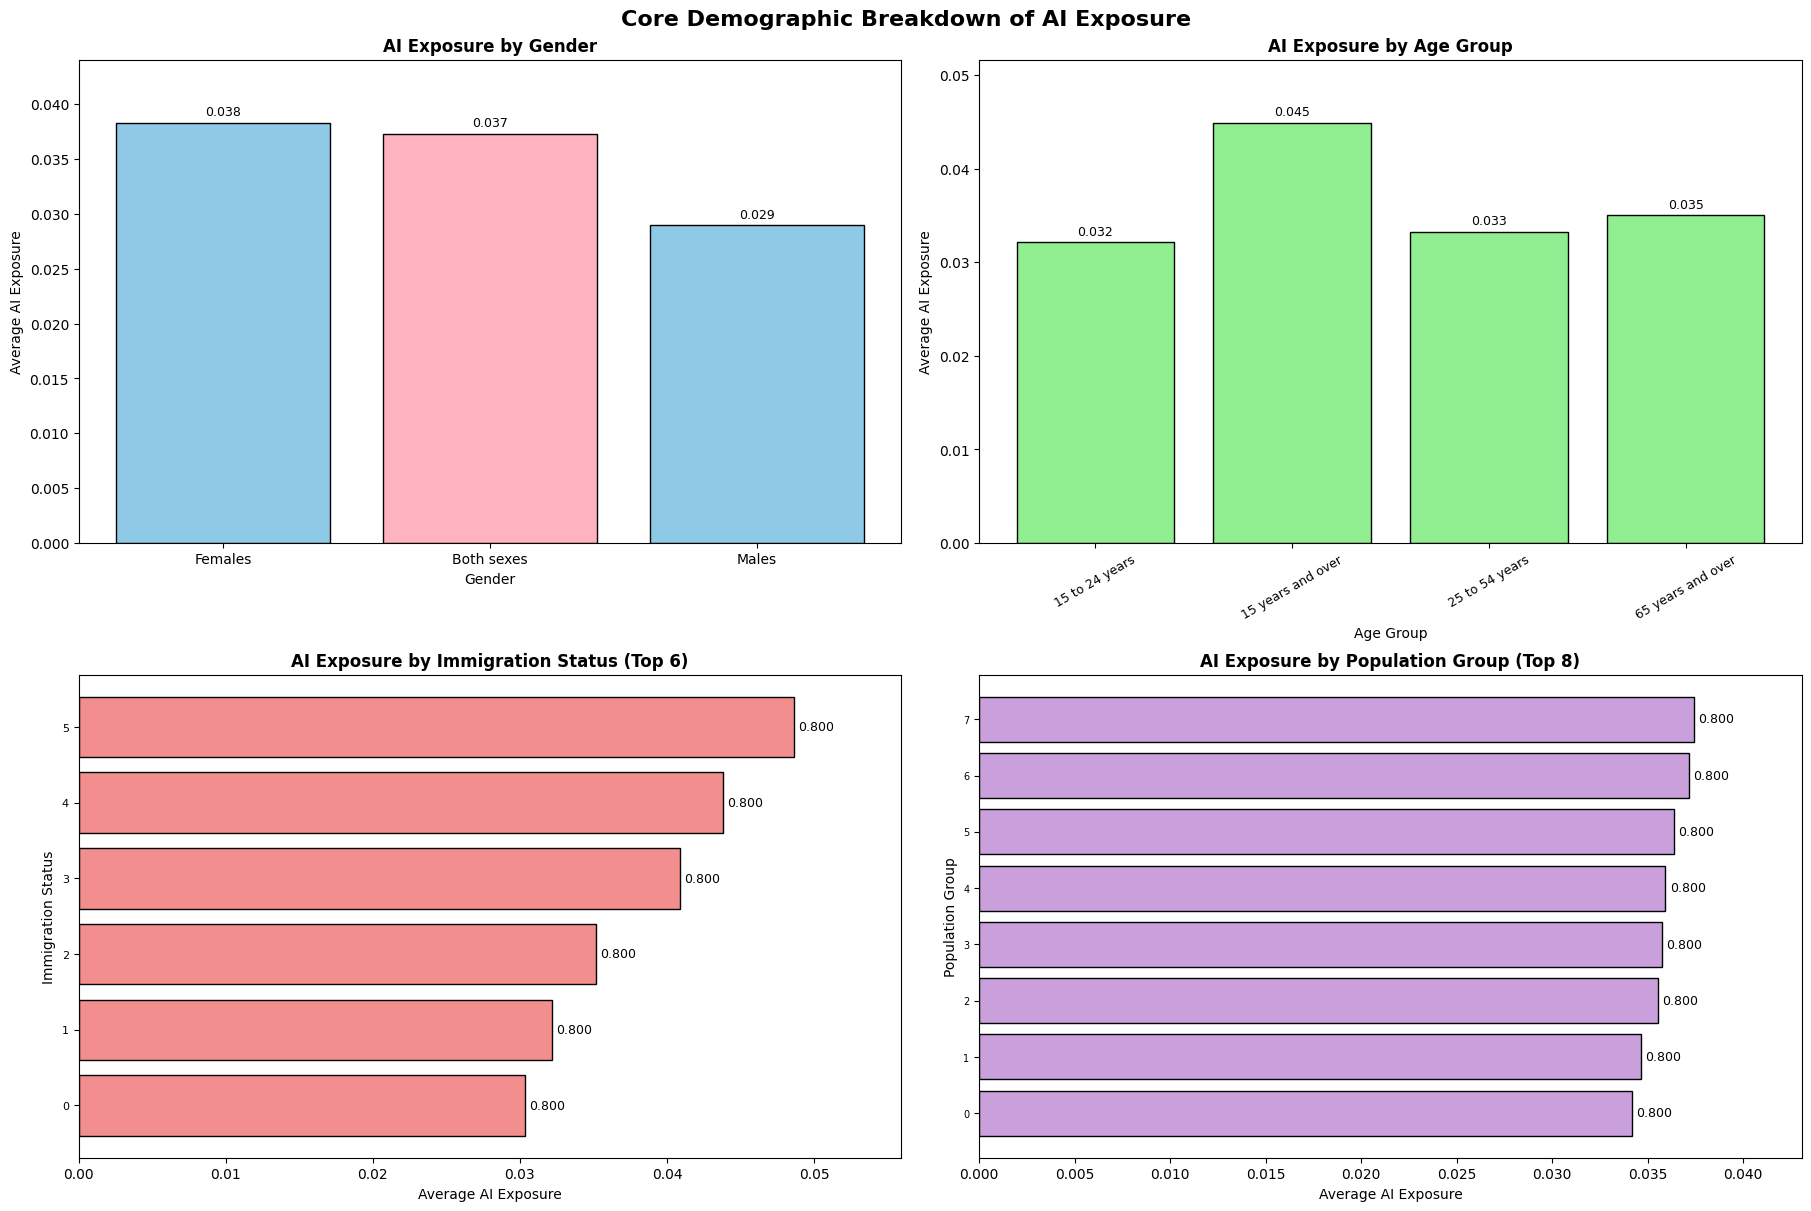

In [21]:
# Core Demographics
def add_bar_labels(ax, bars, fmt="%.3f", padding=3, rotation=0):
    if hasattr(ax, "bar_label"):
        ax.bar_label(bars, labels=[fmt % b.get_height() if hasattr(b, "get_height")
                                   else fmt % b.get_width() for b in bars],
                     padding=padding, rotation=rotation, fontsize=9)
    else:
        for b in bars:
            if hasattr(b, "get_height"):  # vertical
                ax.text(b.get_x()+b.get_width()/2, b.get_height()*1.01, fmt % b.get_height(),
                        ha="center", va="bottom", fontsize=9)
            else:  # horizontal
                ax.text(b.get_width()*1.01, b.get_y()+b.get_height()/2, fmt % b.get_width(),
                        ha="left", va="center", fontsize=9)

def fmt_axis_plain(ax):
    ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
    ax.ticklabel_format(style="plain", axis="y")

fig1, axes = plt.subplots(2, 2, figsize=(18, 12), constrained_layout=True)  # Increased size for better label space

# Gender
ax = axes[0, 0]
bars1 = ax.bar(gender_ai.index.astype(str), gender_ai.values,
               color=["#8ecae6", "#ffb3c1"][:len(gender_ai)], edgecolor="black")
ax.set_title("AI Exposure by Gender", fontweight="bold")
ax.set_xlabel("Gender")
ax.set_ylabel("Average AI Exposure")
ax.set_ylim(0, gender_ai.max()*1.15)
add_bar_labels(ax, bars1, fmt="%.3f")
fmt_axis_plain(ax)

# Age Group
ax = axes[0, 1]
bars2 = ax.bar(age_ai.index.astype(str), age_ai.values, color="#90ee90", edgecolor="black")
ax.set_title("AI Exposure by Age Group", fontweight="bold")
ax.set_xlabel("Age Group")
ax.set_ylabel("Average AI Exposure")
ax.set_ylim(0, age_ai.max()*1.15)
ax.tick_params(axis="x", rotation=30, labelsize=9)
add_bar_labels(ax, bars2, fmt="%.3f")
fmt_axis_plain(ax)

# Immigration Status
ax = axes[1, 0]
top_imm_core = immigrant_ai.head(6).sort_values()
wrapped_idx = [textwrap.fill(str(s), width=30) for s in top_imm_core.index]  # Increased wrap width
bars3 = ax.barh(wrapped_idx, top_imm_core.values, color="#f28e8e", edgecolor="black")
ax.set_title("AI Exposure by Immigration Status (Top 6)", fontweight="bold")
ax.set_xlabel("Average AI Exposure")
ax.set_ylabel("Immigration Status")
ax.set_xlim(0, top_imm_core.max()*1.15)
add_bar_labels(ax, bars3, fmt="%.3f")
ax.tick_params(axis='y', labelsize=8)  # Smaller fontsize for long labels
fmt_axis_plain(ax)

# Population Group
ax = axes[1, 1]
if len(pop_group_ai) > 0:
    topN = min(8, len(pop_group_ai))
    pg = pop_group_ai.head(topN).sort_values()
    wrapped_pg = [textwrap.fill(str(s), width=35) for s in pg.index]
    bars4 = ax.barh(wrapped_pg, pg.values, color="#c9a0dc", edgecolor="black")
    ax.set_title("AI Exposure by Population Group (Top 8)", fontweight="bold")
    ax.set_xlabel("Average AI Exposure")
    ax.set_ylabel("Population Group")
    ax.set_xlim(0, pg.max()*1.15)
    add_bar_labels(ax, bars4, fmt="%.3f")
    ax.tick_params(axis='y', labelsize=7)
    fmt_axis_plain(ax)
else:
    ax.text(0.5, 0.5, "Population group not available", ha="center", va="center",
            transform=ax.transAxes, fontsize=12)
    ax.set_axis_off()

plt.suptitle('Core Demographic Breakdown of AI Exposure', fontsize=16, fontweight='bold')
plt.show()

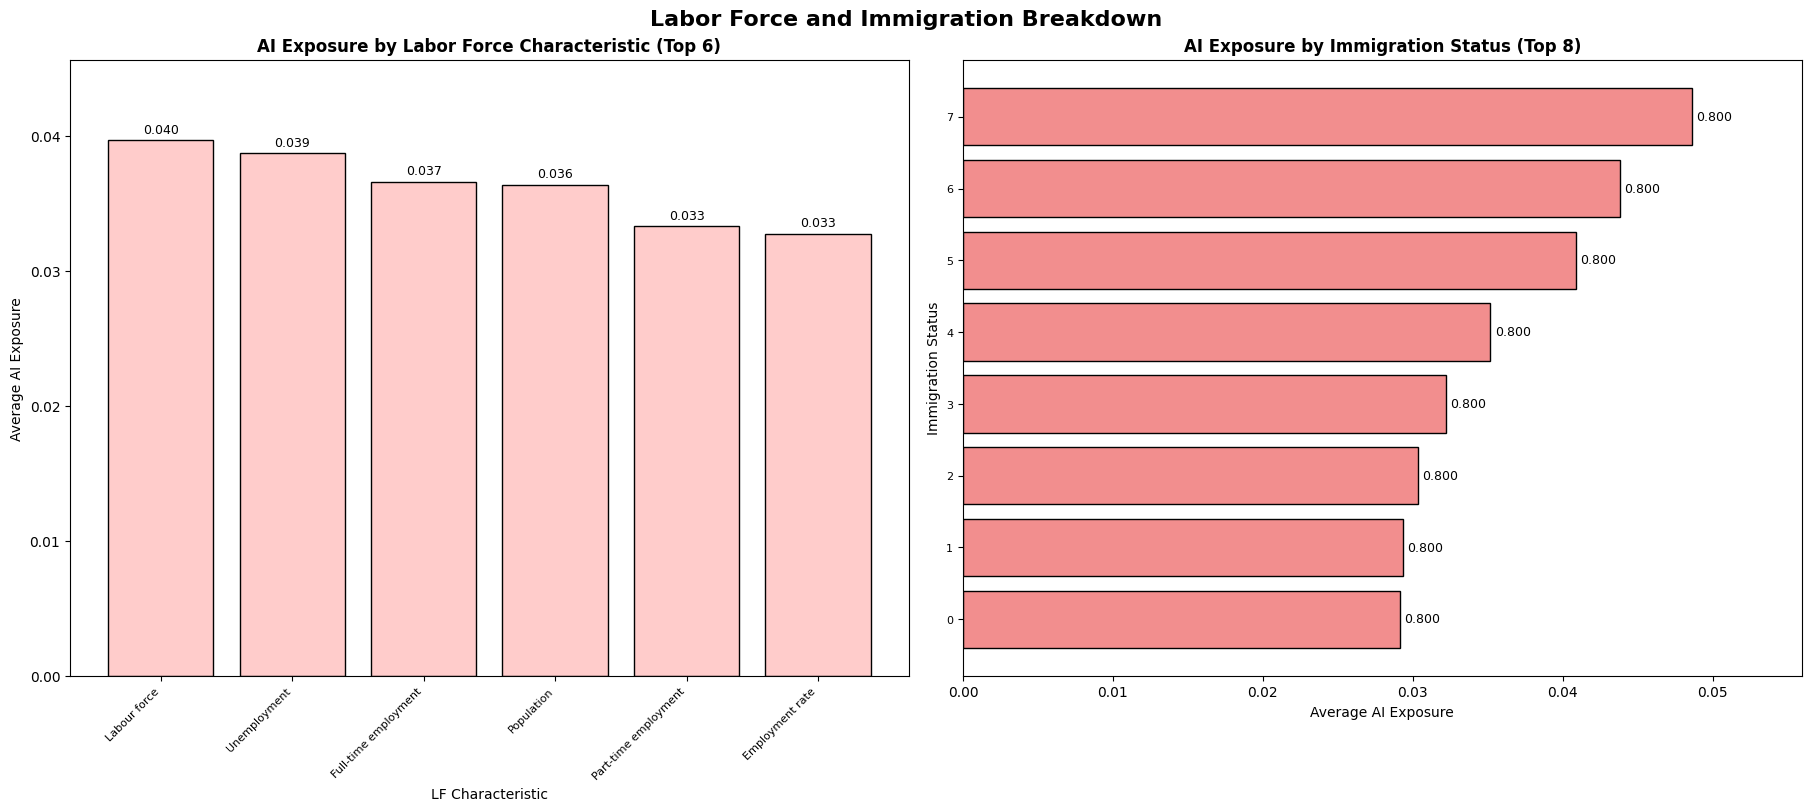

In [22]:
# Labor Force & Extended Demographics
import matplotlib.pyplot as plt
import textwrap

fig2, axes = plt.subplots(1, 2, figsize=(18, 8), constrained_layout=True)  # Increased height

# Labor Force Characteristics (top 6, vertical with rotation)
ax = axes[0]
if len(lf_ai) > 0:
    top_lf = lf_ai.head(6)
    bars_lf = ax.bar(range(len(top_lf)), top_lf.values, color="#ffcccb", edgecolor="black")
    ax.set_title("AI Exposure by Labor Force Characteristic (Top 6)", fontweight="bold")
    ax.set_xlabel("LF Characteristic")
    ax.set_ylabel("Average AI Exposure")
    ax.set_ylim(0, top_lf.max()*1.15)
    ax.set_xticks(range(len(top_lf)))
    ax.set_xticklabels([str(s) for s in top_lf.index], rotation=45, ha='right', fontsize=8)
    add_bar_labels(ax, bars_lf, fmt="%.3f")
    fmt_axis_plain(ax)
else:
    ax.text(0.5, 0.5, "LF Characteristic not available", ha="center", va="center",
            transform=ax.transAxes, fontsize=12)
    ax.set_axis_off()

# Enhanced Immigration (top 8, horizontal with better wrapping)
ax = axes[1]
top_imm = immigrant_ai.head(8).sort_values()
wrapped_imm = [textwrap.fill(str(s), width=35) for s in top_imm.index]  # Increased wrap
bars_imm = ax.barh(wrapped_imm, top_imm.values, color="#f28e8e", edgecolor="black")
ax.set_title("AI Exposure by Immigration Status (Top 8)", fontweight="bold")
ax.set_xlabel("Average AI Exposure")
ax.set_ylabel("Immigration Status")
ax.set_xlim(0, top_imm.max()*1.15)
add_bar_labels(ax, bars_imm, fmt="%.3f")
ax.tick_params(axis='y', labelsize=8)
fmt_axis_plain(ax)

plt.suptitle('Labor Force and Immigration Breakdown', fontsize=16, fontweight='bold')
plt.show()

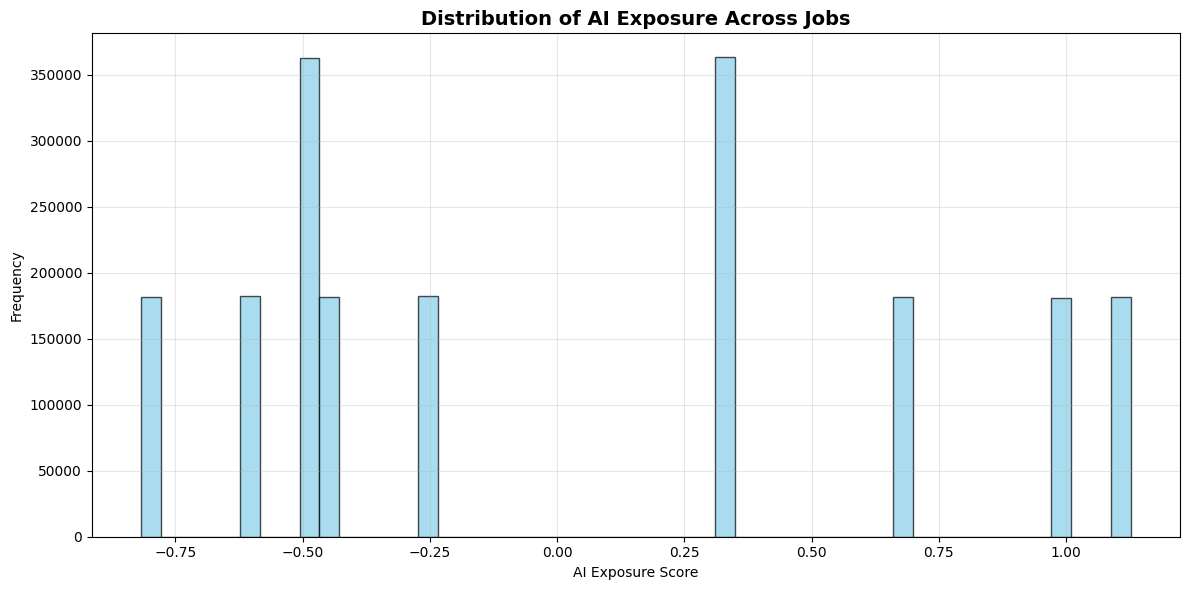

In [27]:
# AI Exposure Distribution
plt.figure(figsize=(12, 6))

# Histogram of AI exposure
plt.hist(df_reduced['ai_exposure'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('AI Exposure Score')
plt.ylabel('Frequency')
plt.title('Distribution of AI Exposure Across Jobs', fontweight='bold', fontsize=14)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

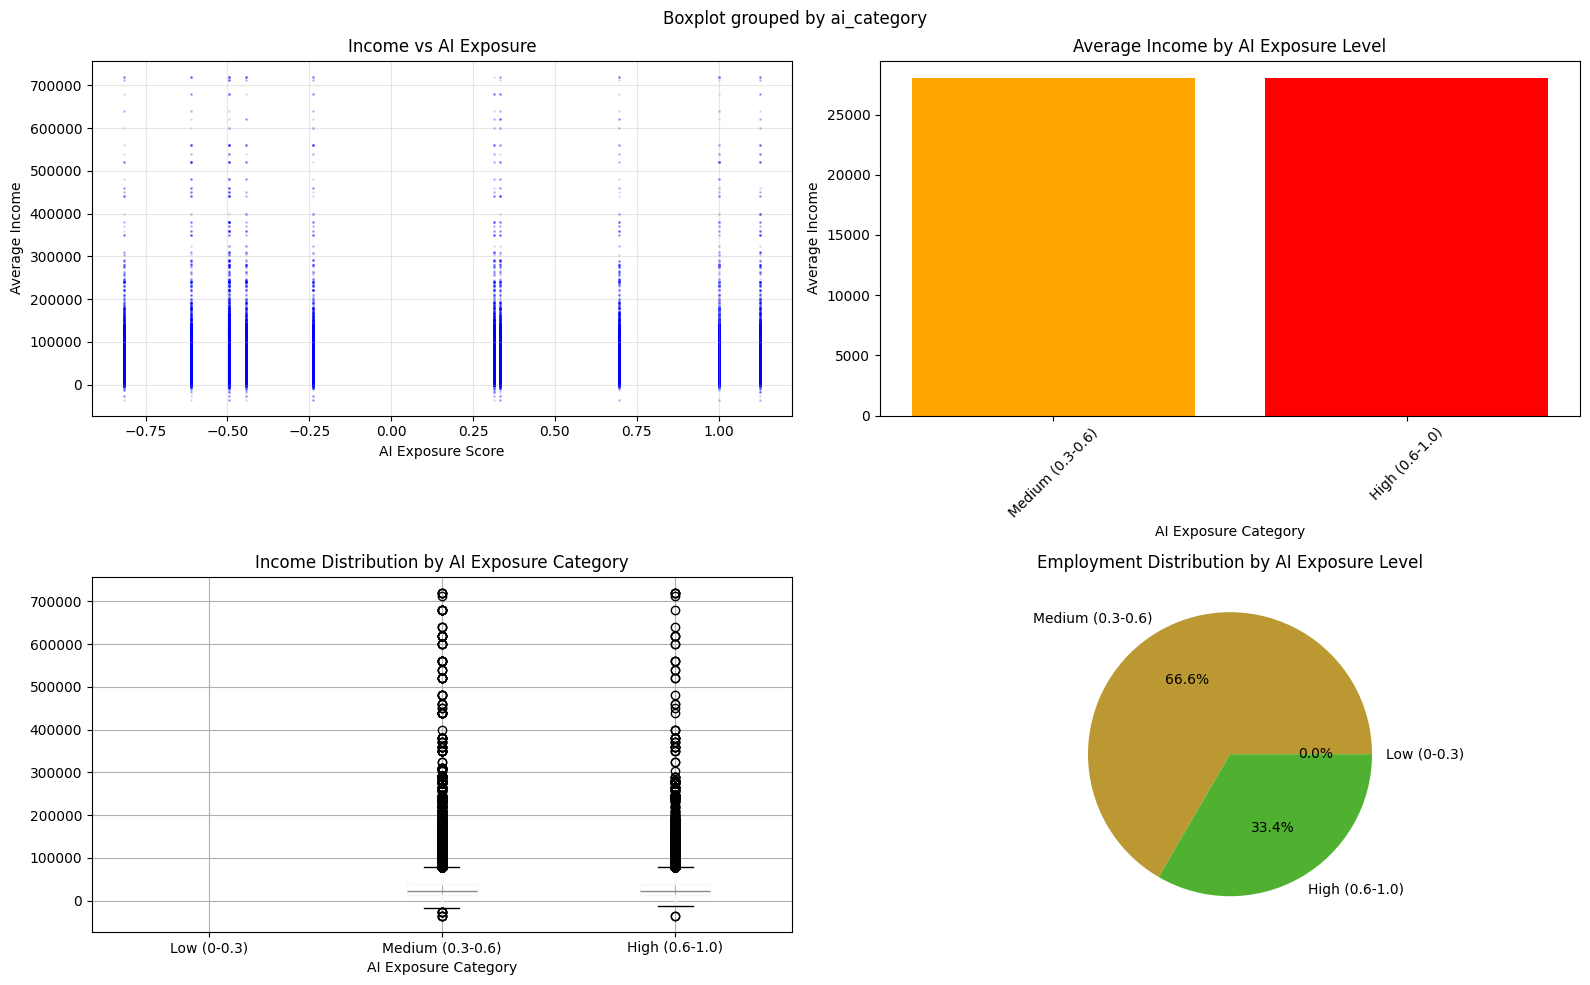

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Scatter plot: Income vs AI Exposure
axes[0,0].scatter(df_reduced['ai_exposure'], df_reduced['average_income'],
                 alpha=0.1, color='blue', s=1)
axes[0,0].set_xlabel('AI Exposure Score')
axes[0,0].set_ylabel('Average Income')
axes[0,0].set_title('Income vs AI Exposure')
axes[0,0].grid(True, alpha=0.3)

# Create AI exposure categories
df_reduced['ai_category'] = pd.cut(df_reduced['ai_exposure'],
                                  bins=[0, 0.3, 0.6, 1.0],
                                  labels=['Low (0-0.3)', 'Medium (0.3-0.6)', 'High (0.6-1.0)'])

# Average income by AI category
income_by_ai = df_reduced.groupby('ai_category')['average_income'].mean()
axes[0,1].bar(income_by_ai.index, income_by_ai.values, color=['green', 'orange', 'red'])
axes[0,1].set_xlabel('AI Exposure Category')
axes[0,1].set_ylabel('Average Income')
axes[0,1].set_title('Average Income by AI Exposure Level')
axes[0,1].tick_params(axis='x', rotation=45)

# Boxplot of income by AI category
df_reduced.boxplot(column='average_income', by='ai_category', ax=axes[1,0])
axes[1,0].set_title('Income Distribution by AI Exposure Category')
axes[1,0].set_xlabel('AI Exposure Category')

# Employment count by AI category
employment_by_ai = df_reduced['ai_category'].value_counts().sort_index()
axes[1,1].pie(employment_by_ai.values, labels=employment_by_ai.index, autopct='%1.1f%%')
axes[1,1].set_title('Employment Distribution by AI Exposure Level')

plt.tight_layout()
plt.show()

## Key Insights

In [28]:
# Print Key Insights (weighted consistently)
total_employment = df_reduced['value_x'].sum()
print(f"Total employment analyzed: {total_employment:,.0f}")

# Share of high-AI-exposure jobs (weighted)
high_ai_share = (df_reduced['value_x'].dot(df_reduced['high_exposure']) / total_employment) * 100
# print(f"High AI exposure jobs (>0.7): {high_ai_share:.1f}%")

# Weighted average income by exposure group
high_income = income_by_ai['High (0.6-1.0)']
low_income = income_by_ai['Low (0-0.3)']
print(f"Weighted average income - High AI: ${high_income:,.0f}")

# Highest exposure by demographics (weighted)
print(f"\nHighest AI exposure by Labour Force Characteristic: {lf_ai.index[0]} ({lf_ai.iloc[0]:.3f})")
print(f"Highest AI exposure by Population Group: {pop_group_ai.index[0]} ({pop_group_ai.iloc[0]:.3f})")
print(f"Highest AI exposure by Immigration Status: {immigrant_ai.index[0]} ({immigrant_ai.iloc[0]:.3f})")

Total employment analyzed: 29,767,599,770
Weighted average income - High AI: $28,047

Highest AI exposure by Labour Force Characteristic: Labour force (0.040)
Highest AI exposure by Population Group: Latin American (0.037)
Highest AI exposure by Immigration Status: Second generation (0.049)


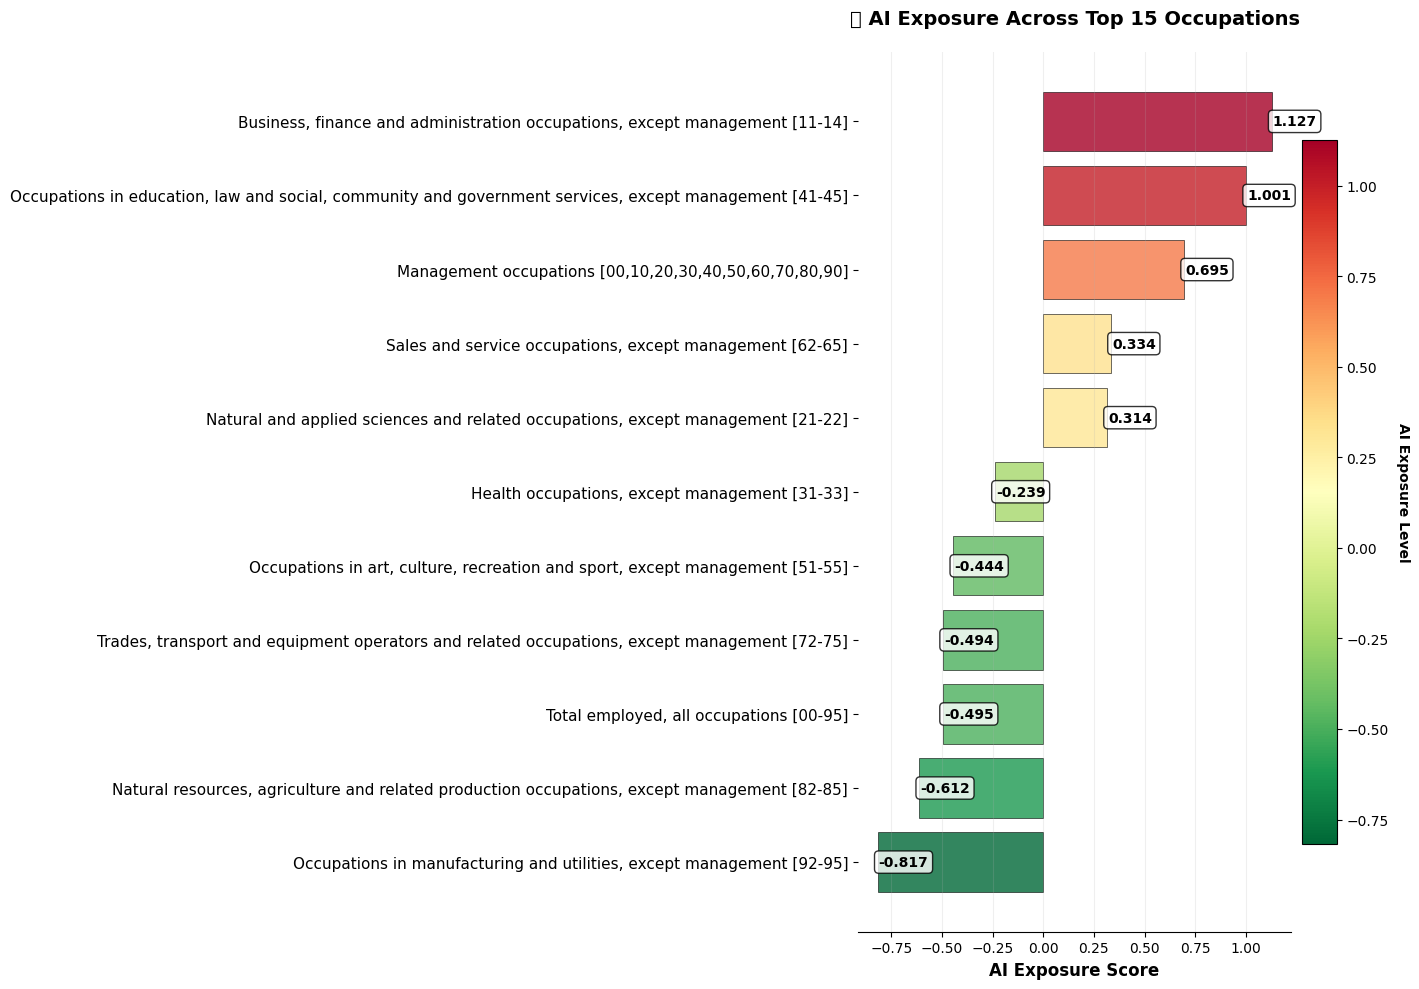

In [29]:
# Top Occupations
fig5, ax = plt.subplots(figsize=(14, 10))

# Gradient colors
colors = plt.cm.RdYlGn_r((occupation_means.values - occupation_means.min()) /
                         (occupation_means.max() - occupation_means.min()))

bars = ax.barh(range(len(occupation_means)), occupation_means.values,
               color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

ax.set_yticks(range(len(occupation_means)))
ax.set_yticklabels(occupation_means.index, fontsize=11)
ax.set_xlabel('AI Exposure Score', fontsize=12, fontweight='bold')
ax.set_title('🤖 AI Exposure Across Top 15 Occupations', fontsize=14, fontweight='bold', pad=20)

# Labels
for i, (v, bar) in enumerate(zip(occupation_means.values, bars)):
    ax.text(v + 0.005, i, f'{v:.3f}',
            va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Styling
ax.grid(True, alpha=0.2, axis='x')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Colorbar
sm = plt.cm.ScalarMappable(cmap='RdYlGn_r',
                          norm=plt.Normalize(occupation_means.min(), occupation_means.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label('AI Exposure Level', rotation=270, labelpad=15, fontweight='bold')

plt.tight_layout()
plt.show()

### AI Exposure Across Occupations

**What the chart shows**
Average **AI-exposure scores** by broad occupation group.

* Bars to the **right (red/orange)** = higher exposure (more tasks likely to be impacted/augmented by AI).
* Bars to the **left (green)** = lower exposure.
* **Zero** is the mid-point.

**Highest exposure (prioritize upskilling)**

* **Business, finance & administration** — **+1.13**
* **Education, law, social/community & government services** — **+1.00**
* **Management** — **+0.70**
* **Sales & service** — **+0.33**
* **Natural & applied sciences** — **+0.31**
  *These are information-heavy roles with a lot of analytical, communication, and documentation tasks—prime candidates for AI augmentation.*

**Lower exposure (more task insulation today)**

* **Health** — **−0.24**
* **Arts, culture, recreation & sport** — **−0.44**
* **Trades, transport & equipment operators** — **−0.49**
* **Natural resources & agriculture** — **−0.61**
* **Manufacturing & utilities** — **−0.82**
  *These roles lean on hands-on, physical, or tightly regulated tasks where current AI substitutes less.*

**Economy benchmark**

* **Total employed (all occupations)** sits near **−0.50**, so the average job skews toward **lower AI exposure**.

**Bottom line**
AI will **first reshape white-collar work**. Focus reskilling and policy on business/admin, public sector/education, and management, while tracking wage and vacancy changes there. Manual and production roles see **slower direct AI impact** today (though robotics/automation still matter).
